In [2]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set(font_scale = 2.5)
plt.rcParams['figure.figsize'] = (12, 9)

In [3]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [4]:
data = pd.read_excel("Data/Simulation Results/growth rates no test delays adherence.xlsx", index_col = 0)
days_simulated = 25

In [5]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,reduce_contacts_by,two_step_tracing,prob_has_trace_app,hh_prob_will_take_up_isolation,prob_household_prop_not_adhere,prob_not_adhere,...,15,16,17,18,19,20,21,22,23,24
0,0.231106,0.2,0.718844,2.106095,0.099972,True,0.115266,0.950957,0.359191,0.042312,...,98776,119222,143650,172772,207388,248477,297352,354647,422872,503365
1,0.244234,0.4,0.796399,1.512811,0.641072,False,0.178651,0.984372,0.054515,0.044750,...,21446,22740,23950,25137,26292,27387,28395,29385,30324,31313
2,0.231106,0.2,0.806044,1.819440,0.092250,False,0.218168,0.852651,0.173096,0.026417,...,100752,122203,147895,178424,214885,258273,309535,370442,443026,529395
3,0.224541,0.1,0.889043,2.091538,0.294209,False,0.176088,0.781617,0.091619,0.010462,...,59894,69943,81563,94832,110041,127762,147873,170984,197280,227798
4,0.250799,0.5,0.730299,2.269109,0.092115,True,0.123674,0.692576,0.439470,0.012400,...,110198,134315,163455,198384,239853,290104,350503,422856,510595,615699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.250799,0.5,0.838883,1.652846,0.395947,False,0.359123,0.932143,0.491210,0.036802,...,41840,46273,50999,56059,61341,66898,72705,78706,85200,92019
96,0.237670,0.3,0.845674,2.484362,0.618055,True,0.484623,0.631055,0.447574,0.049421,...,24879,26848,28837,31034,33295,35551,37918,40394,42949,45483
97,0.244234,0.4,0.809567,2.462712,0.807878,False,0.232988,0.775518,0.141944,0.045623,...,13075,13487,13837,14153,14451,14756,15002,15255,15487,15701
98,0.244234,0.4,0.931731,1.953330,0.340988,False,0.306874,0.924125,0.232419,0.029355,...,49560,55954,62632,69857,77671,85807,94454,103768,113778,124618


In [6]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

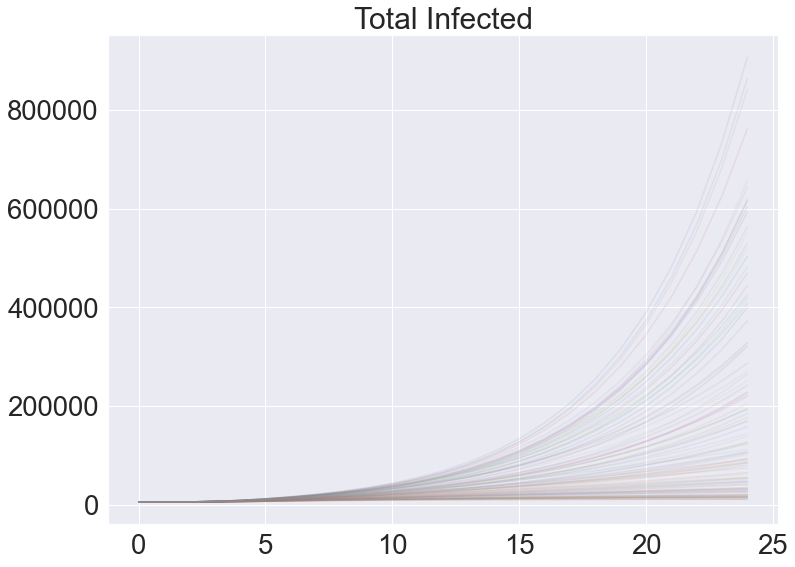

In [7]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

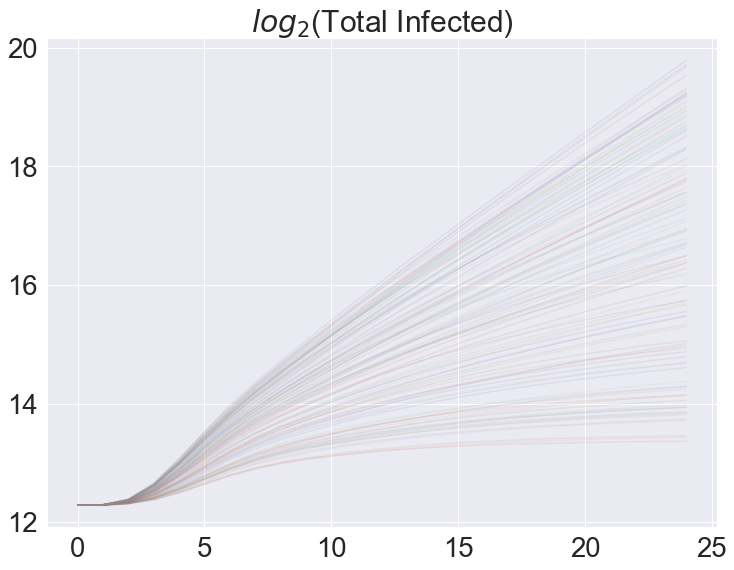

In [8]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

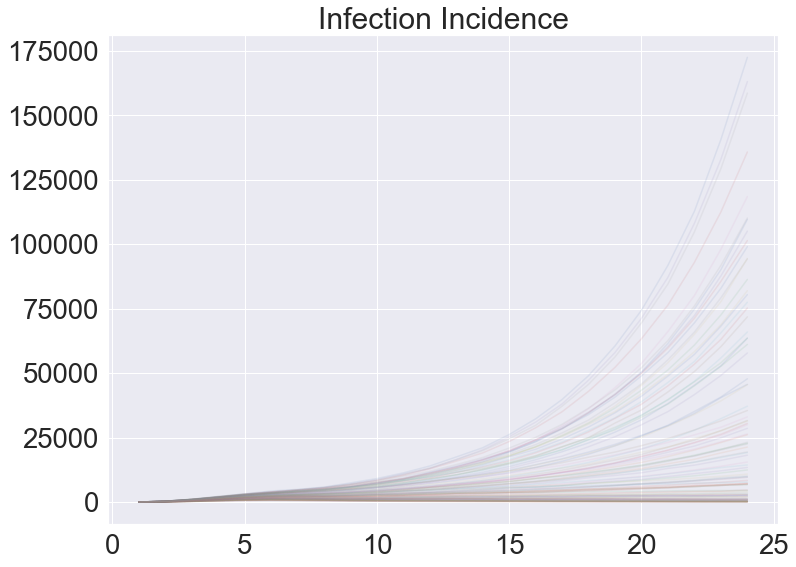

In [9]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

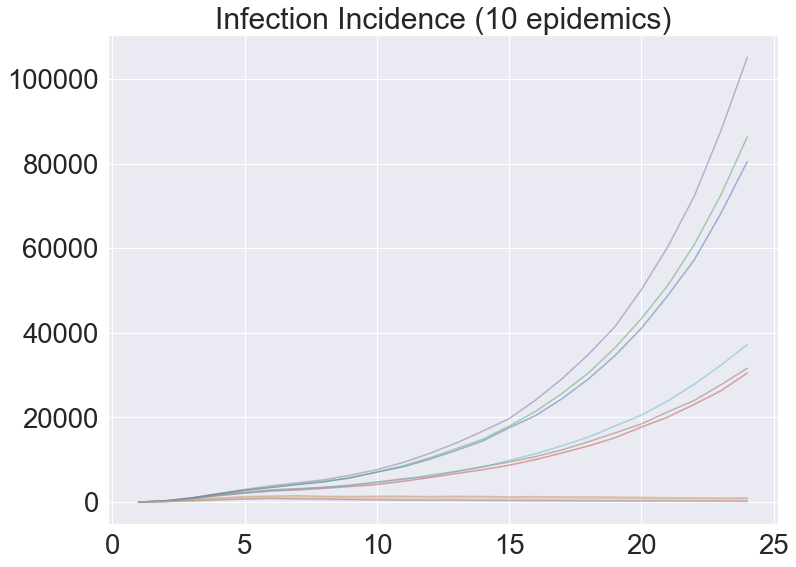

In [10]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

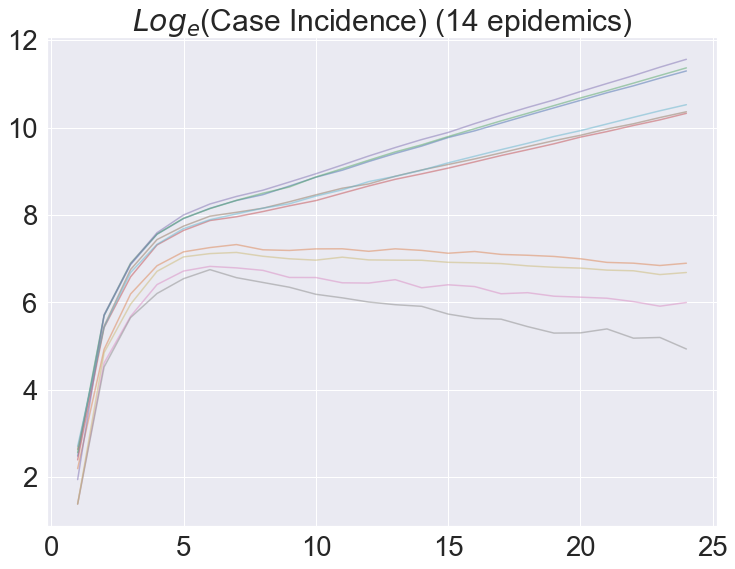

In [11]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [12]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.337e+04
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           7.07e-25
Time:                        11:33:26   Log-Likelihood:                 47.674
No. Observations:                  15   AIC:                            -91.35
Df Residuals:                      13   BIC:                            -89.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9461      0.011    611.980      0.0

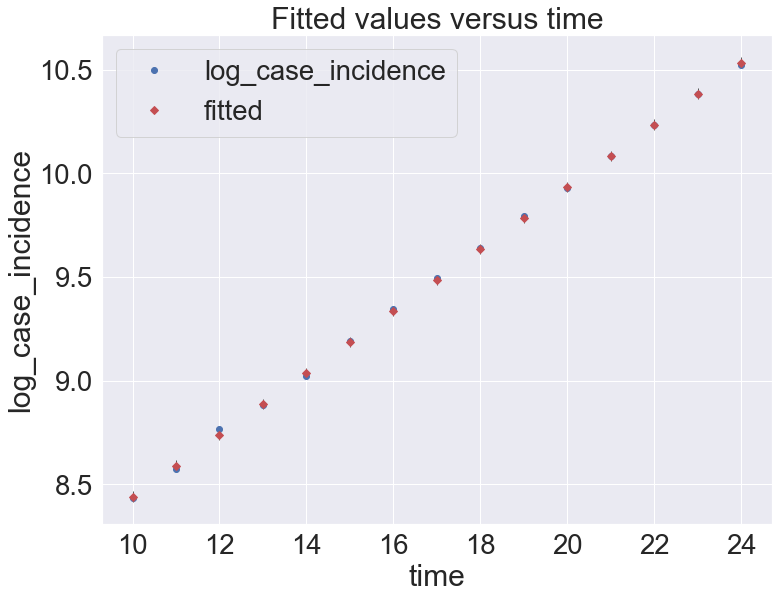

In [13]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [14]:
data_subset = infection_counts

In [15]:
growth_rates = []
doubling_times = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [16]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

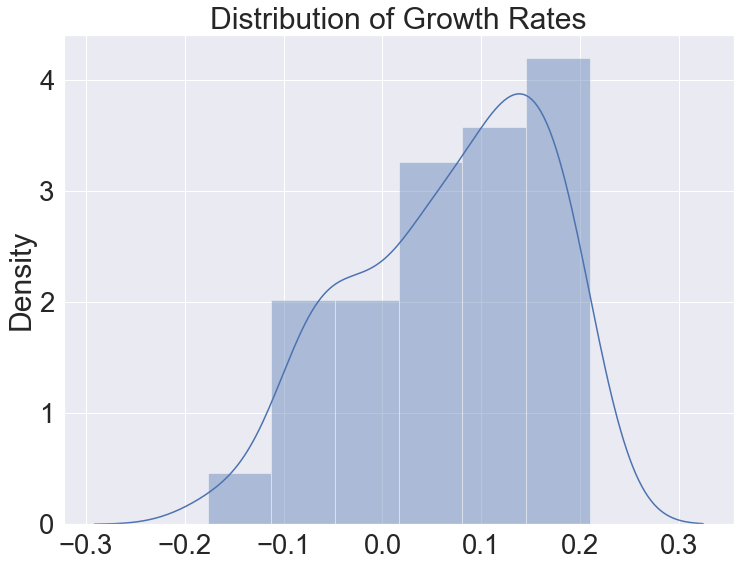

In [17]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [18]:
data_pars = data[data.columns[0:10]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [19]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,reduce_contacts_by,two_step_tracing,prob_has_trace_app,hh_prob_will_take_up_isolation,prob_household_prop_not_adhere,prob_not_adhere,growth_rate
0,0.231106,0.2,0.718844,2.106095,0.099972,True,0.115266,0.950957,0.359191,0.042312,0.173833
1,0.244234,0.4,0.796399,1.512811,0.641072,False,0.178651,0.984372,0.054515,0.044750,-0.028560
2,0.231106,0.2,0.806044,1.819440,0.092250,False,0.218168,0.852651,0.173096,0.026417,0.177222
3,0.224541,0.1,0.889043,2.091538,0.294209,False,0.176088,0.781617,0.091619,0.010462,0.139065
4,0.250799,0.5,0.730299,2.269109,0.092115,True,0.123674,0.692576,0.439470,0.012400,0.185212
...,...,...,...,...,...,...,...,...,...,...,...
95,0.250799,0.5,0.838883,1.652846,0.395947,False,0.359123,0.932143,0.491210,0.036802,0.053807
96,0.237670,0.3,0.845674,2.484362,0.618055,True,0.484623,0.631055,0.447574,0.049421,0.032812
97,0.244234,0.4,0.809567,2.462712,0.807878,False,0.232988,0.775518,0.141944,0.045623,-0.074351
98,0.244234,0.4,0.931731,1.953330,0.340988,False,0.306874,0.924125,0.232419,0.029355,0.072906


                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1545.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           1.30e-95
Time:                        12:30:44   Log-Likelihood:                 356.46
No. Observations:                 100   AIC:                            -688.9
Df Residuals:                      88   BIC:                            -657.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Text(0, 0.5, 'Halving / doubling times (days)')

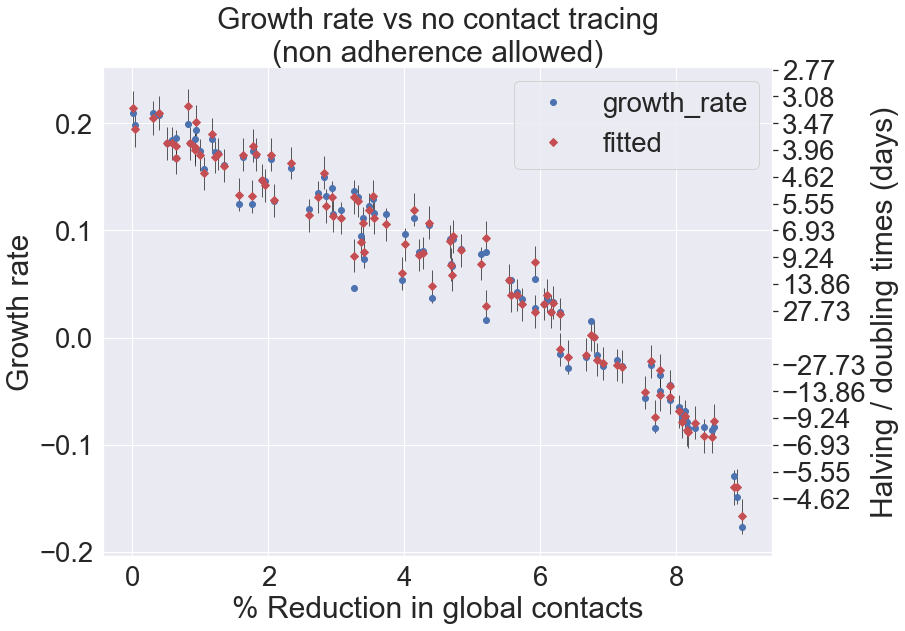

In [24]:
y, X = dmatrices('growth_rate ~  two_step_tracing + I(reduce_contacts_by*10) + I(I(reduce_contacts_by*10)**2) + I(I(reduce_contacts_by*10)**3) + I(I(reduce_contacts_by*10)**4) + I(I(prob_has_trace_app*10)**2) + I(contact_tracing_success_prob*10) + contact_trace_delay_par + I(infection_reporting_prob*10) + I(I(infection_reporting_prob*10)**2) + I(hh_prob_will_take_up_isolation*10)', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "I(reduce_contacts_by * 10)", ax = ax)

y_vals = np.linspace(-0.15, 0.25, 17)
y_vals = np.concatenate((y_vals[:6], y_vals[7:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylabel("Growth rate")
plt.xlabel("% Reduction in global contacts")
plt.title("Growth rate vs no contact tracing\n(non adherence allowed)")
ax2.set_ylabel("Halving / doubling times (days)")

In [25]:
res.conf_int(alpha = 0.05)

array([[ 3.09940883e-01,  3.52334743e-01],
       [-3.77948355e-03,  2.39343017e-03],
       [-3.44876005e-02, -1.09211110e-02],
       [-7.59103106e-03,  2.93582259e-03],
       [-3.46105649e-04,  1.40350519e-03],
       [-9.92498355e-05, -2.90835378e-06],
       [-3.54692212e-04,  1.01992919e-04],
       [-8.09087074e-03, -3.74841491e-03],
       [ 1.53294138e-03,  1.17788299e-02],
       [-1.30265429e-02, -1.55524085e-03],
       [-8.49488703e-04,  1.05725615e-03],
       [-1.09125254e-02, -8.61465344e-03]])

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

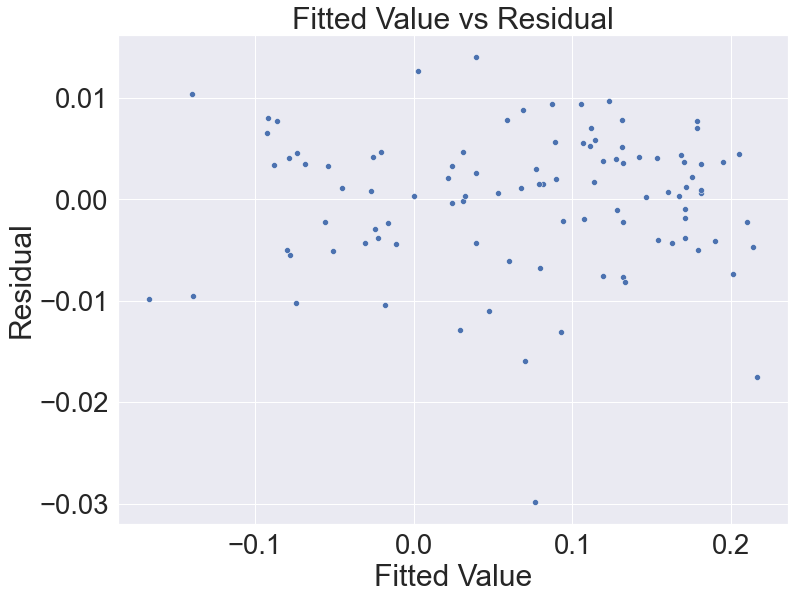

In [20]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

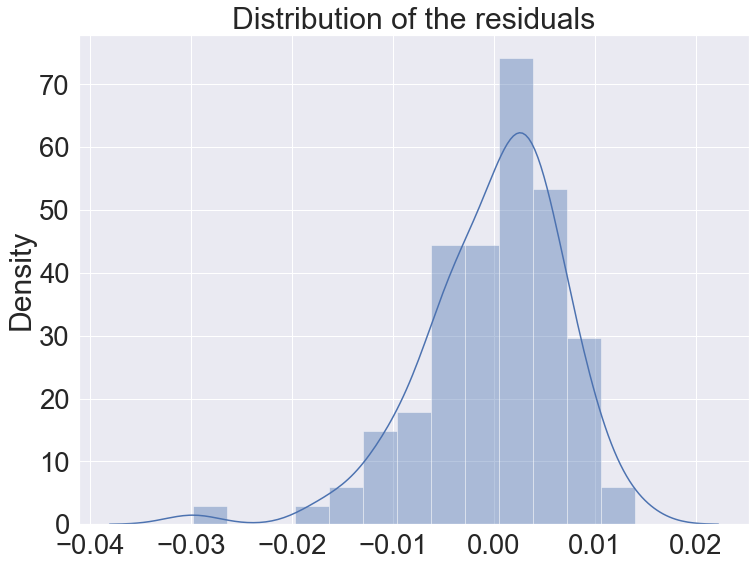

In [21]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

## Comparison to reference curve

In [22]:
reference_coefs = pd.read_excel("Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**3,coef_contact_reduction**4
0,0.219887,-0.185921,-0.260727,0.422797,-0.414373


In [23]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**3"].loc[0]
beta_3 = reference_coefs["coef_contact_reduction**4"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3 +beta_3*x**4

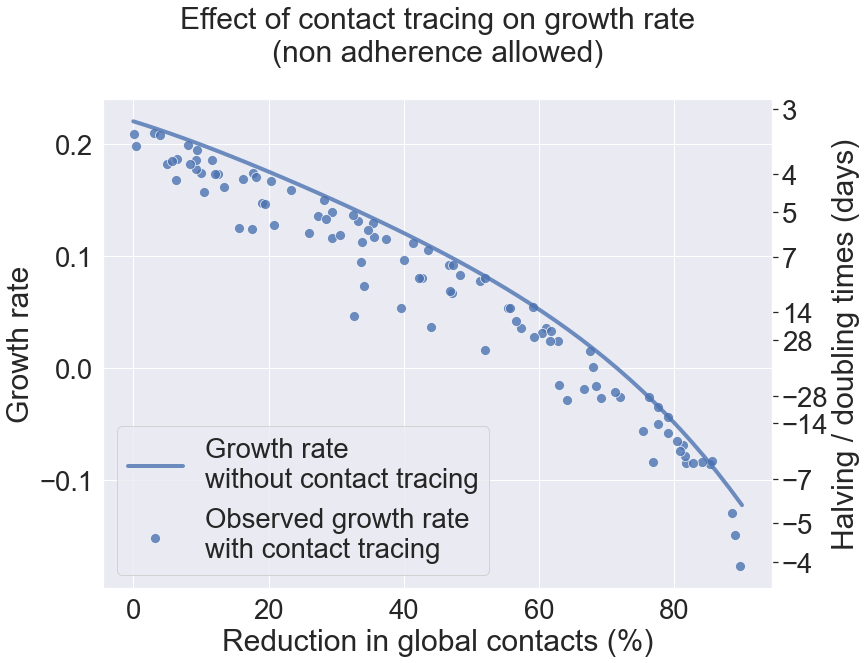

In [27]:
fig, ax = plt.subplots()

#y_vals = np.linspace(-0.175, 0.25, 18)
#y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

y_vals = [doubling_time_to_growth_rate(x) for x in [-3, -4, -5, -7, -14, -28, 28, 14, 7, 5, 4, 3]]

sns.scatterplot(data_pars["reduce_contacts_by"] * 100, data_pars['growth_rate'], alpha = 0.8, s = 100)

plt.plot(x * 100, y, linewidth = 4, alpha = 0.8)

ax2 = ax.secondary_yaxis("right", functions=(growth_rate_to_doubling_time, doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.ylabel("Growth rate")
plt.xlabel("Reduction in global contacts (%)")
plt.title("Effect of contact tracing on growth rate\n(non adherence allowed)\n")
ax2.set_ylabel("Halving / doubling times (days)")
plt.legend(("Growth rate\nwithout contact tracing", "Observed growth rate\nwith contact tracing"))
plt.savefig("Figures/Simulation - no test delay adherence model/growth_rate_comparison.pdf", bbox_inches = 'tight')
plt.savefig("Figures/Simulation - no test delay adherence model/growth_rate_comparison.jpg", bbox_inches = 'tight')
plt.savefig("Figures/Simulation - no test delay adherence model/growth_rate_comparison.png", bbox_inches = 'tight')